In [2]:
import pandas as pd
import numpy as np
import sys, os

In [18]:
#Pre-process the dataset
input_path='/fastscratch/c-panz/2021-09-14'
output_path='/pod/2/li-lab/Ziwei/Nanopore/daily/2021-09-14'
df_T4=pd.read_csv(os.path.join(input_path, 'T4.test.100.bed'), sep='\t')
df_lambda=pd.read_csv(os.path.join(input_path, 'lambda.test.200.bed'), sep='\t')
df_5mClambda=pd.read_csv(os.path.join(input_path, 'lambda_5mC.test.300.bed'), sep='\t')

In [9]:
# Add the label column
df_T4['label'] = '5hmC'
df_lambda['label'] = '5C'
df_5mClambda['label'] = '5mC'
# Merge the dataset 
df = pd.concat([df_T4, df_5mClambda, df_lambda])

# Create label column
# Createa a label with representations: 5C = 0, 5mC = 1, 5hmC = 2
df['label'] = df['label'].map({'5C':0, '5mC':1, '5hmC':2 })
df.to_csv(os.path.join(input_path, 'total.test.bed'), sep='\t', index = None)

In [10]:
#Splitting the data into independent and dependent variables
df_feature = df.loc[:,['5hmC_prob','5mC_prob','5C_prob']].values
df_class = df.loc[:,['label']].values
df_class = np.squeeze(df_class) #Convert the label into 1d-array

In [22]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from statistics import mean

# https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb
# Build the random forest model
example_params = {
        'n_estimators': 20,
        'max_depth': 5,
        'random_state': 42
    }

rf_model = RandomForestClassifier(**example_params)

#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Randomly spilt dataset to traing/testing dataset with the original ratio
X_train, X_test, y_train, y_test = train_test_split(df_feature, 
                                                    df_class, 
                                                    test_size=0.2, 
                                                    stratify=df_class)

In [99]:

#https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb
scoring = ('accuracy', 'recall_macro', 'f1_macro')

#f1_macro = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
#print('Mean f1_macro: %.3f' % mean(f1_macro))

#Evaluate SRF model
scores = cross_validate(rf_model, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
scores

#Get average evaluation metrics
print('Mean accuracy: %.3f' % mean(scores['test_accuracy']))
print('Mean recall_macro: %.3f' % mean(scores['test_recall_macro']))
print('Mean f1_macro: %.3f' % mean(scores['test_f1_macro']))

Mean accuracy: 0.932
Mean recall_macro: 0.909
Mean f1_macro: 0.906


In [100]:
scores = pd.DataFrame(scores)
scores.to_csv(os.path.join(output_path, 'scores.csv'), header = True, index= None, sep = ',', float_format='%.4f')

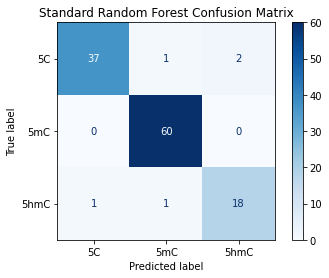

In [61]:
#Ploting the confusion matrix
#https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

target_class = ['5C', '5mC', '5hmC']

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
fig = plot_confusion_matrix(rf_model, X_test, y_test, 
                            display_labels=target_class, cmap='Blues'
                           )
plt.title('Standard Random Forest Confusion Matrix')
plt.show()

In [78]:
confusion_matrix(y_test, y_pred)

array([[37,  1,  2],
       [ 0, 60,  0],
       [ 1,  1, 18]])

In [85]:
# Plot confusion matrix
#https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'True label'
    cm.columns.name = 'Predicted label'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap="Greens")
    plt.savefig(filename)

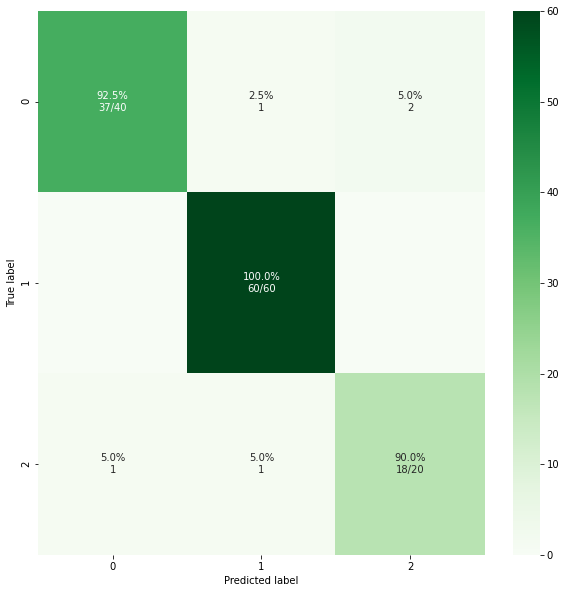

In [88]:
cm_analysis(y_test, y_pred, os.path.join(output_path, 'test.png'),
            labels = None, ymap=None, figsize=(10,10))

In [102]:
# Save the classification report
# https://stackoverflow.com/a/53780589

from sklearn.metrics import classification_report
target_class = ['5C', '5mC', '5hmC']
report = classification_report(y_test, y_pred, target_names=target_class, output_dict=True)
df = pd.DataFrame(report).transpose()
df.head(3)

,precision,recall,f1-score,support
5C,0.973684,0.925,0.948718,40.0
5mC,0.967742,1.000,0.983607,60.0
5hmC,0.900000,0.900,0.900000,20.0


In [103]:
df.to_csv(os.path.join(output_path, 'class_report.csv'), header = True, index= None, sep = ',', float_format='%.4f')